In [1]:
# Install if you haven't
# !pip install sounddevice

In [37]:
import pandas as pd 
import numpy as np 
import plotly.express as px 
import plotly.graph_objects as go 
import cv2
import sounddevice as sd
import tensorflow as tf
from tensorflow.keras.models import load_model  # or the relevant library if you used something else
import threading
import time 
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [38]:
model_video = load_model("EmotionDetectionImageModel.keras")
model_audio = load_model('AudioDetectionEmotionModel.keras')

C:\Users\Bojana\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [56]:
# Emotion labels 
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
emotion_colors = ['red', 'green', 'black', 'green', 'yellow','blue', 'purple']

### Function for plotting a star chart 
Each arm of the star represents one emotion & the length of each arm corresponds to the predicted probability of that emotion.

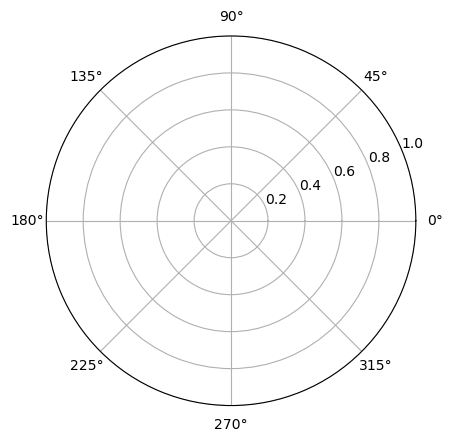

In [49]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

In [50]:
# Calculate where the 7 emotions will be placed on the circle
angles = np.linspace(0, 2 * np.pi, len(emotions), endpoint=False).tolist()
angles += angles[:1]
print(angles)

[0.0, 0.8975979010256552, 1.7951958020513104, 2.6927937030769655, 3.5903916041026207, 4.487989505128276, 5.385587406153931, 0.0]


In [51]:
# Adding them to the ax
ax.set_xticks(angles[:-1])
ax.set_xticklabels(emotions)

[Text(0.0, 0, 'Angry'),
 Text(0.8975979010256552, 0, 'Disgust'),
 Text(1.7951958020513104, 0, 'Fear'),
 Text(2.6927937030769655, 0, 'Happy'),
 Text(3.5903916041026207, 0, 'Neutral'),
 Text(4.487989505128276, 0, 'Sad'),
 Text(5.385587406153931, 0, 'Surprise')]

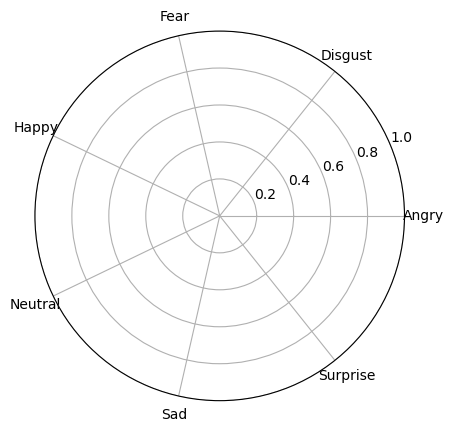

In [52]:
fig

In [53]:
def plot_star_chart(probabilities):
    probabilities = np.concatenate((probabilities, [probabilities[0]]))  # Close the loop
    
    ax.clear()    
    ax.fill(angles, probabilities, color='purple', alpha=0.25) # fills the area between the center and the points
    ax.plot(angles, probabilities, color='purple', linewidth=2) # adds lines to the plot
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions)
    
    fig.canvas.draw()
    
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')  # Convert to numpy array
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to the right format
    plt.close(fig)  # Close the plot to free memory
    
    return img

In [65]:
def scatter(probabilities):
    probabilities = np.concatenate((probabilities, [probabilities[0]]))  # Close the loop
    base_radius = 2 * probabilities
    
    ax.clear()    
    num_layers = 3  # Number of layers/circles around each emotion

    for i, emotion in enumerate(emotions):
        for layer in range(num_layers):
            # Increasing radius for each layer
            r = base_radius[i] + (layer * 0.1)  # Add an offset for each circle layer
            area = 400 * (r**2)  # Size proportional to the radius
            ax.scatter(angles[i], r, c=[emotion_colors[i]], s=area, cmap='hsv', alpha=0.5)

    # Set emotion labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(emotions)

    fig.canvas.draw()
    
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')  # Convert to numpy array
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))  # Reshape to the right format
    plt.close(fig)  # Close the plot to free memory
    
    return img

In [46]:
# Function to resize the chart to match frame height, convert to BGR (OpenCV format) & concatenate the frame + chart
def preprocess_plot_image_to_fit_frame(frame, plotted_image):
    star_chart_img = cv2.resize(plotted_image, (frame.shape[1], frame.shape[0]))
    star_chart_img_bgr = cv2.cvtColor(star_chart_img, cv2.COLOR_RGB2BGR)

    combined_frame = np.hstack((frame, star_chart_img_bgr))
    
    return combined_frame

## Audio functions

In [47]:
# Function to capture and preprocess audio
def get_audio_features():
    duration = 1  # seconds
    sample_rate = 16000
    audio_data = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1)
    sd.wait()  # Wait for the recording to complete
    audio_data = np.mean(audio_data, axis=1)  # Convert stereo to mono if needed
    audio_data = audio_data / np.max(np.abs(audio_data))  # Normalize
    audio_data = np.expand_dims(audio_data, axis=0)  # Match model input shape
    return audio_data

# Function to predict audio emotion in a separate thread
def audio_emotion_detection():
    global audio_probs, running

    while running:
        audio_features = get_audio_features()
        prediction_audio = model_audio.predict(audio_features)[0]
        audio_probs = prediction_audio  # Store the raw probabilities
        time.sleep(2)  # Reduce audio processing frequency


## MAIN RENDER

In [66]:
# Global variables for audio and video predictions
audio_probs = np.zeros(7)  # Placeholder for 7 emotion probabilities
video_probs = np.zeros(7)  # Placeholder for 7 emotion probabilities
running = True  # Flag to control running state

# Start audio detection thread
audio_thread = threading.Thread(target=audio_emotion_detection)
audio_thread.daemon = True
audio_thread.start()

# Initialize the webcam
cap = cv2.VideoCapture(0)  # 0 is the default webcam
frame_skip = 5  # Only predict every 5th frame
frame_count = 0

while running:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    if frame_count % frame_skip == 0:
        # Preprocess the video frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized_frame = cv2.resize(gray, (48, 48))  # Resize to match your model's input size (48x48)
        normalized_frame = resized_frame / 255.0  # Normalize pixel values

        # Reshape the frame to match model input (1, 48, 48, 1)
        input_frame = np.expand_dims(normalized_frame, axis=0)
        input_frame = np.expand_dims(input_frame, axis=-1)

        # Make video model prediction
        prediction_video = model_video.predict(input_frame)[0]
        video_probs = prediction_video  # Store the raw probabilities

    frame_count += 1

    # Combine the probabilities from audio and video
    combined_probs = audio_probs + video_probs

    # Get indices of top 3 emotions
    top_3_indices = np.argsort(combined_probs)[-3:][::-1]  # Sort and get top 3 in descending order
    top_3_emotions = [(emotions[i], combined_probs[i]) for i in top_3_indices]

    # Display the top 3 emotions on the video frame
    label_text = f"1st: {top_3_emotions[0][0]} ({top_3_emotions[0][1]:.2f}), " \
                 f"2nd: {top_3_emotions[1][0]} ({top_3_emotions[1][1]:.2f}), " \
                 f"3rd: {top_3_emotions[2][0]} ({top_3_emotions[2][1]:.2f})"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
    
    #chart_img = plot_star_chart(combined_probs) # Filled radar/star chart
    chart_img = scatter(combined_probs)  # Scatter chart
    combined_frame = preprocess_plot_image_to_fit_frame(frame, chart_img)
   
    
    # Display the combined image
    cv2.imshow('Emotion Detection and Visualization', combined_frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        running = False  # Stop both audio and video when 'q' is pressed

# Wait for the audio thread to finish
audio_thread.join()

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\Bojana\AppData\Local\Temp\ipykernel_10628\2398520074.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(angles[i], r, c=[emotion_colors[i]], s=area, cmap='hsv', alpha=0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━